In [1]:
from src.models.bounding_box import BoundingBox
from src.models.vertex import Vertex
from src.services.data_converter_service import DataConverterService
from src.services.image_display_serivce import ImageDisplayService
from src.services.line_detection_service import LineDetectionService

from config import config

"""
    getting a single datapoint from the dataset
"""

converter_service = DataConverterService() 
datapoint = converter_service.load_single_datapoint(str(0))

In [2]:
from src.services.predict_symbols_service import PredictSymbolsService
from src.models.symbol import Symbol
from src.utils.convert_points_to_bounding_box import convert_points_to_bounding_box


"""
    predict the symbol bounding boxes using the prediction service.
"""

predicted_symbol_results = []

predict_service = PredictSymbolsService(
    image_path=datapoint.image_path,
    model_path="./yolo-model-pid.pt"
)

prediction_results = predict_service.predict_bounding_boxes()

for index, pr in enumerate(prediction_results):
    symbol = Symbol(
        name=f"s-{str(index)}",
        label=pr[1],
        pointSrc=Vertex(x=pr[0][0], y=pr[0][1]),
        pointDest=Vertex(x=pr[0][2], y=pr[0][3])
    )

    predicted_symbol_results.append(symbol)


0: 1088x512 1 4, 1 10, 1 13, 1 28, 225.4ms
Speed: 3.4ms preprocess, 225.4ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 512)
time took to finish prediction: 1.3589627742767334


In [3]:


"""
    predict the word bounding boxes using the azure document inteligence service.
"""

from src.services.predict_word_service import PredictWordService

word_bboxes = []
predict_word_service = PredictWordService(
    image_path=datapoint.image_path
)

result = predict_word_service.predicit_bounding_boxes()

for index, item in enumerate(result): 
    word_bboxes.append(
        BoundingBox(
            name=f"w-{index}",
            pointSrc=Vertex(x=item[0],y=item[1]),
            pointDest=Vertex(x=item[2],y=item[3])
        )
    )

jpg
time took to finish word prediction: 1.687345266342163


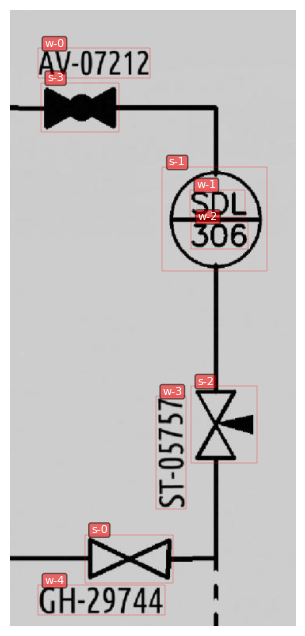

In [4]:
display_service = ImageDisplayService(
    datapoint.image_path,
    [*predicted_symbol_results, *word_bboxes]
)
display_service.display_image_with_bbox(color='red', dpi=100)

In [5]:
from src.utils.calculate_distance_between_rectangles import calculate_distance_between_rectangles

"""
    remove redundent bounding boxes.
"""

index_to_delete = []

for index_1, s1 in enumerate(predicted_symbol_results):
    for index_2, s2 in enumerate(predicted_symbol_results[index_1 + 1:]):
        if(
            calculate_distance_between_rectangles(
                [*s1.pointSrc.get_dimensions(), *s1.pointDest.get_dimensions()], 
                [*s2.pointSrc.get_dimensions(), *s2.pointDest.get_dimensions()]                
            ) < 5
        ):
            index_to_delete.append(index_1)


predicted_symbol_results = [value for i, value in enumerate(predicted_symbol_results) if i not in list(set(index_to_delete))]

In [7]:
# line detection and their extension from the datapoint
line_detection_service = LineDetectionService(
    image_path=datapoint.image_path,
    bounding_boxes=[*predicted_symbol_results, *word_bboxes],
)

line_segments = [convert_points_to_bounding_box(l) for l in line_detection_service.extend_lines(
    line_detection_service.detect_line_segments(enable_thining=True)
)]

for index, l in enumerate(line_segments):
    l.name = f"l-{str(index)}"

In [8]:
# filter the smaller lines, make them bigger than ususal. Implement them in the line service afterwards.

from src.utils.calculate_distance_between_points import calculate_distance_between_points

short_line_semgents = list(filter(lambda l: l.name in ['l-0', 'l-10'], line_segments))

print(short_line_semgents)
[calculate_distance_between_points(s.pointSrc.get_dimensions(), s.pointDest.get_dimensions()) for s in short_line_semgents]

[BoundingBox(name='l-0', pointSrc=Vertex(x=257.0, y=479.0), pointDest=Vertex(x=261.0, y=325.0)), BoundingBox(name='l-10', pointSrc=Vertex(x=257.0, y=793.0), pointDest=Vertex(x=261.0, y=750.0))]


[154.0519392932137, 43.18564576337837]

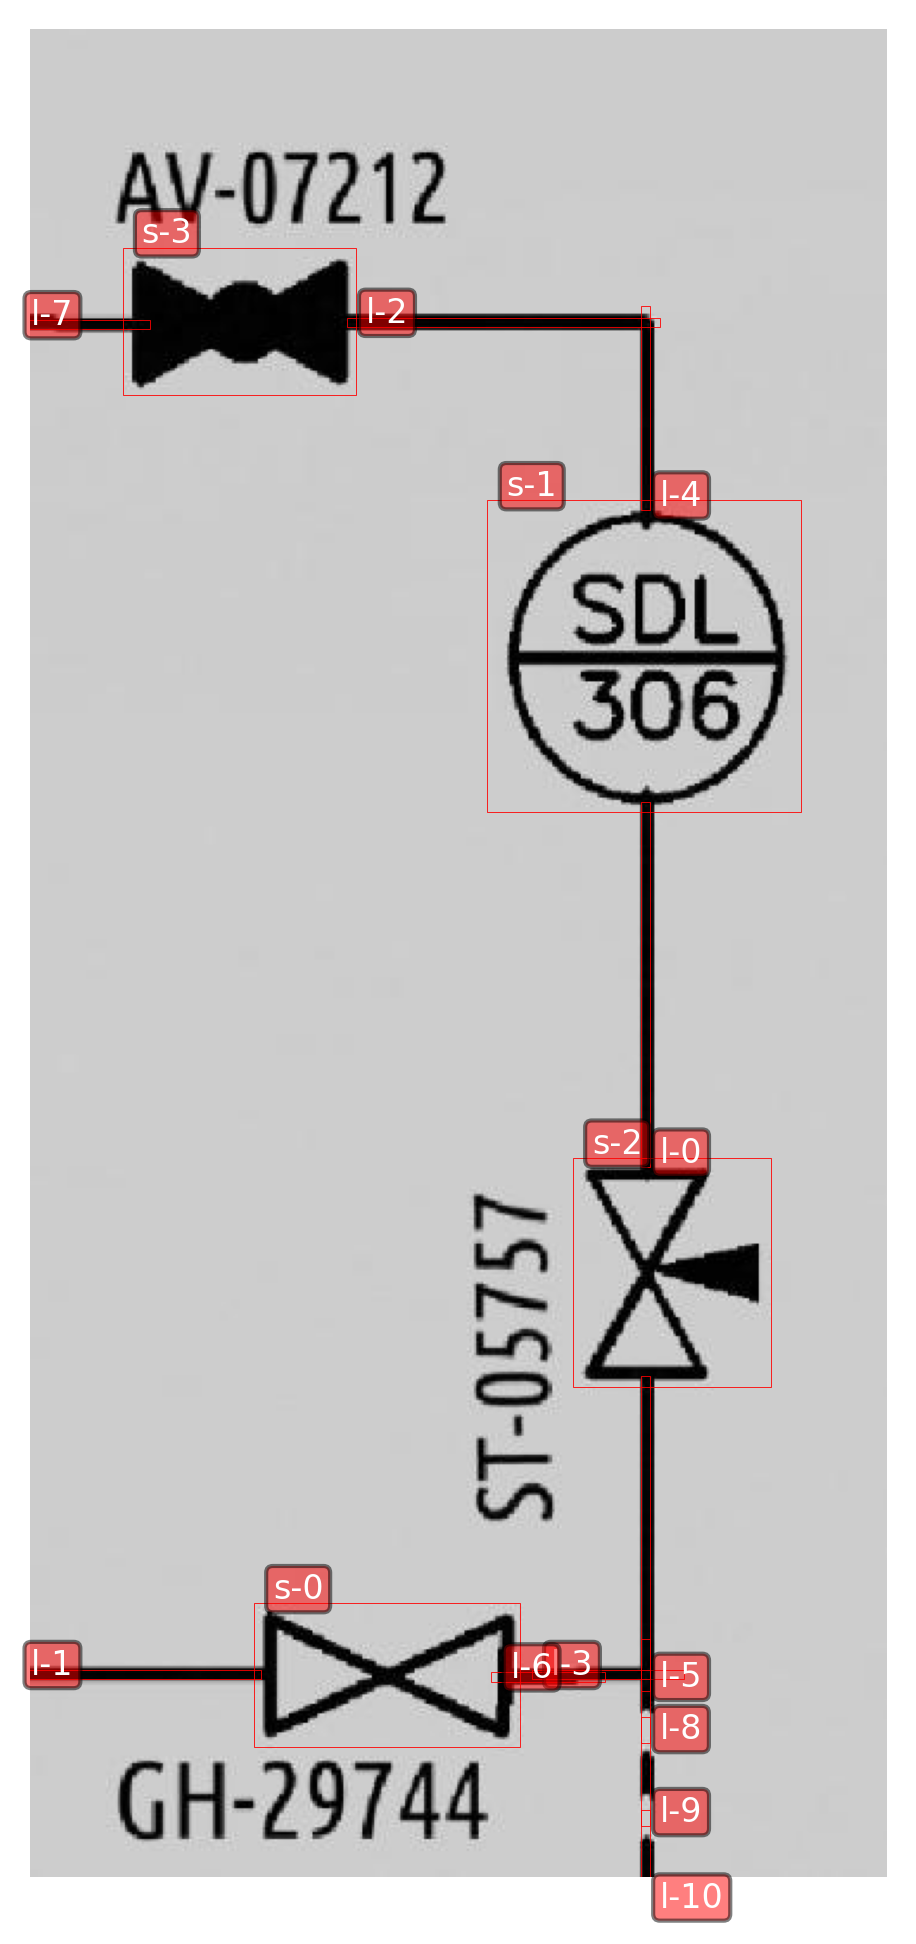

In [9]:
line_display_service = ImageDisplayService(
    datapoint.image_path,
    [*line_segments, *predicted_symbol_results]
)

line_display_service.display_image_with_bbox(color='red', dpi=300)

In [10]:
from src.services.graph_construction_service import GraphConstructionService

graph_service = GraphConstructionService(predicted_symbol_results, line_segments)
graph_service.initialize_graph()
graph_service.define_graph_edges()

<Figure size 640x480 with 0 Axes>

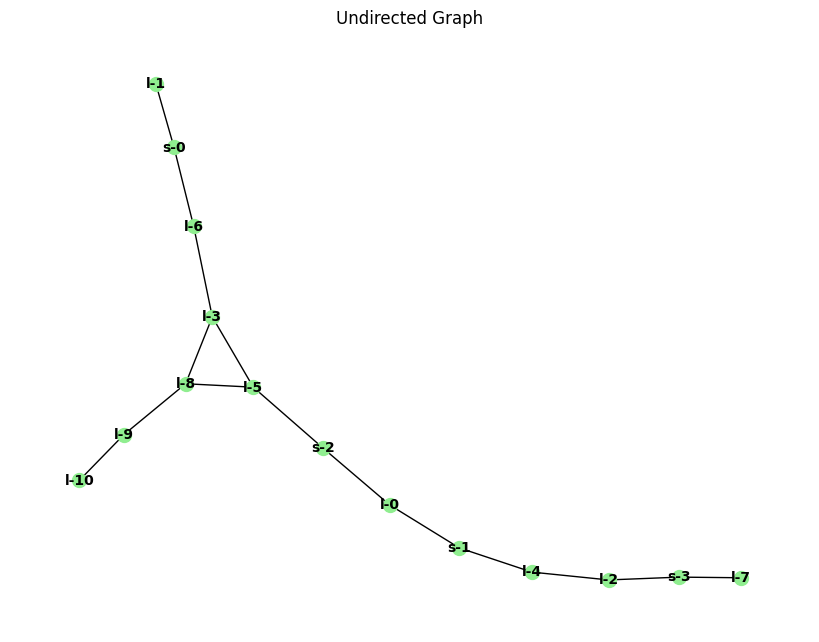

In [11]:
service = ImageDisplayService()
service.display_graph(graph_service.graph)

In [12]:
[graph_service.get_line_cycle_list(degree=4), graph_service.get_line_cycle_list(degree=3)]

[[], [['l-3', 'l-5', 'l-8']]]

In [13]:
graph_service.reduce_line_cycles()
graph_service.set_largest_graph_connected_nodes()

<Figure size 640x480 with 0 Axes>

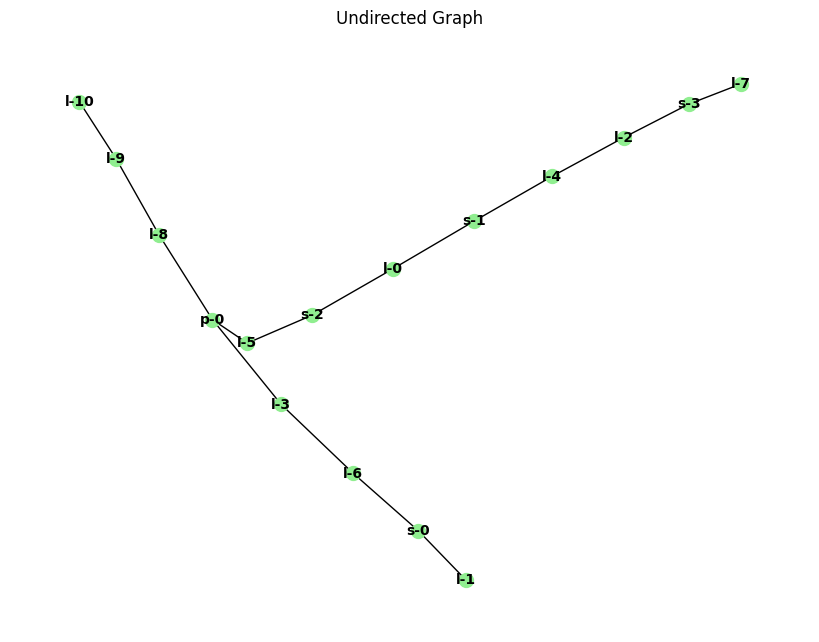

In [14]:
service.display_graph(graph_service.graph)

In [15]:
for i in range(100):
    graph_service.remove_single_connection_line_nodes()

<Figure size 640x480 with 0 Axes>

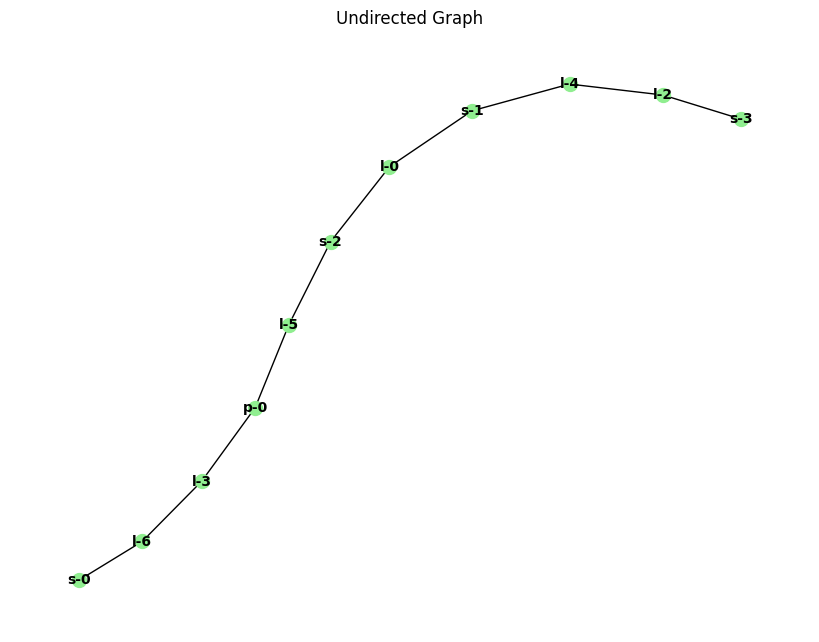

In [16]:
service.display_graph(graph_service.graph)

In [17]:
# this part is where I will do the graph contractions.
from typing import List
import networkx as nx
from src.enums.graph_node_type import GraphNodeType

def uniqify_paths(G, paths):
    unique_paths = []
    seen = []
    
    for path in paths:
        subgraph = G.subgraph(path)
        
        # Check if it is isomorphic to any previously seen subgraph
        if not any(nx.is_isomorphic(subgraph, G.subgraph(seen_path)) for seen_path in seen):
            seen.append(path)
            unique_paths.append(path)
    
    return unique_paths


def line_node_to_edges(graph):
    # get all the symbol nodes
    symbol_and_connector_nodes = [node for node, data in graph_service.graph.nodes(data=True) if data['type'] in [GraphNodeType.connector, GraphNodeType.symbol]]
    print('symbol and connector nodes', symbol_and_connector_nodes)
    node_to_node_paths = []
    for u in symbol_and_connector_nodes:
        for v in symbol_and_connector_nodes:
            if u != v:
                # push only those links to array that have symbols at boths ends.
                for path in list(nx.all_simple_paths(graph, source=u, target=v)):
                    all_lines = path[1: -1]
                    if len(all_lines) > 1 and all(graph.nodes[l]['type'] == GraphNodeType.line for l in all_lines):
                        valid_path = True
                        for i in range(1, len(path) - 1):
                            neighbors = list(graph.neighbors(path[i]))
                            if not all(neighbor in [path[i-1], path[i+1]] for neighbor in neighbors):
                                valid_path = False
                                break
                        if valid_path:
                            node_to_node_paths.append(path)

    node_to_node_paths = uniqify_paths(graph, node_to_node_paths)

    for path in node_to_node_paths:
        last_node = path[len(path) - 1]
        first_line = path[1]
        graph.add_edge(first_line, last_node)

        for node in path[2:len(path) - 1]:
            if graph.has_node(node): graph.remove_node(node)

for i in range(10):
    line_node_to_edges(graph_service.graph)

symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']
symbol and connector nodes ['s-0', 's-1', 's-2', 's-3', 'p-0']


<Figure size 640x480 with 0 Axes>

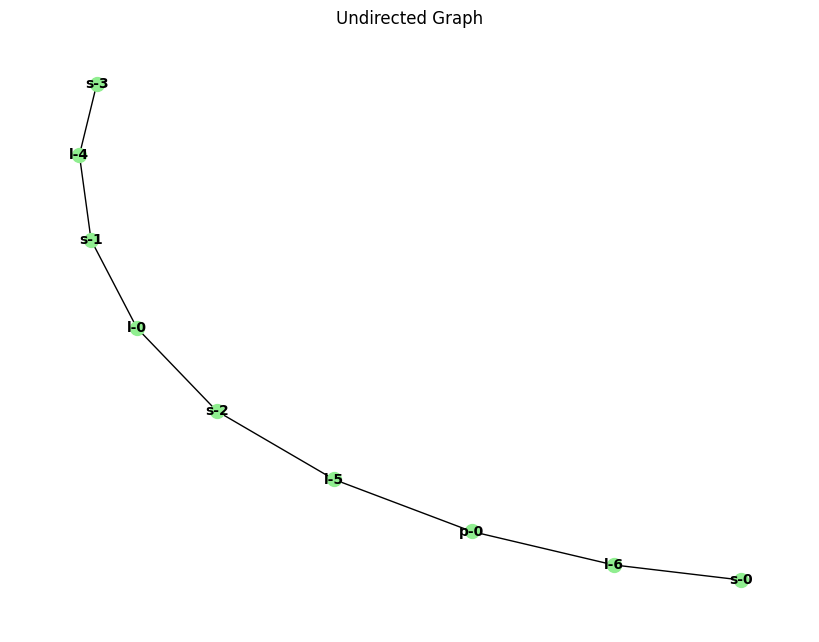

In [19]:
service.display_graph(graph_service.graph)

'<graphml xmlns="http://graphml.graphdrawing.org/xmlns" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">\n  <key id="d0" for="node" attr.name="type" attr.type="string" />\n  <graph edgedefault="undirected">\n    <node id="l-0">\n      <data key="d0">line</data>\n    </node>\n    <node id="l-4">\n      <data key="d0">line</data>\n    </node>\n    <node id="l-5">\n      <data key="d0">line</data>\n    </node>\n    <node id="l-6">\n      <data key="d0">line</data>\n    </node>\n    <node id="s-0">\n      <data key="d0">symbol</data>\n    </node>\n    <node id="s-1">\n      <data key="d0">symbol</data>\n    </node>\n    <node id="s-2">\n      <data key="d0">symbol</data>\n    </node>\n    <node id="s-3">\n      <data key="d0">symbol</data>\n    </node>\n    <node id="p-0">\n      <data key="d0">connector</data>\n    </node>\n    <edge source="l-0" target="s-1" />\n    <edg

<Figure size 640x480 with 0 Axes>

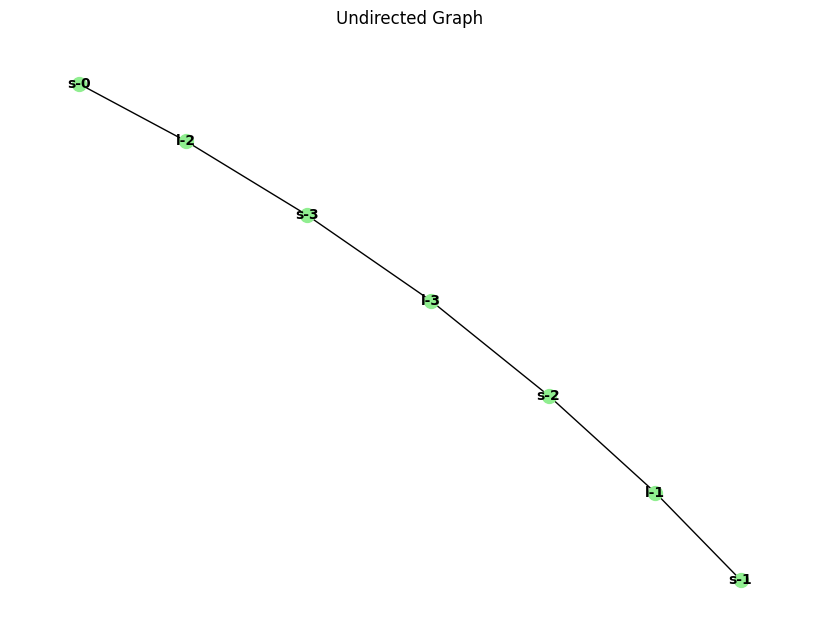

In [20]:
from matplotlib import pyplot as plt
import networkx as nx

read = nx.parse_graphml(
    """
        <graphml xmlns=\"http://graphml.graphdrawing.org/xmlns\" xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" xsi:schemaLocation=\"http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd\">\n  <key id=\"d1\" for=\"node\" attr.name=\"label\" attr.type=\"string\" />\n  <key id=\"d0\" for=\"node\" attr.name=\"type\" attr.type=\"string\" />\n  <graph edgedefault=\"undirected\">\n    <node id=\"l-1\">\n      <data key=\"d0\">line</data>\n    </node>\n    <node id=\"l-2\">\n      <data key=\"d0\">line</data>\n    </node>\n    <node id=\"l-3\">\n      <data key=\"d0\">line</data>\n    </node>\n    <node id=\"s-0\">\n      <data key=\"d0\">symbol</data>\n      <data key=\"d1\">7</data>\n    </node>\n    <node id=\"s-1\">\n      <data key=\"d0\">symbol</data>\n      <data key=\"d1\">21</data>\n    </node>\n    <node id=\"s-2\">\n      <data key=\"d0\">symbol</data>\n      <data key=\"d1\">28</data>\n    </node>\n    <node id=\"s-3\">\n      <data key=\"d0\">symbol</data>\n      <data key=\"d1\">28</data>\n    </node>\n    <edge source=\"l-1\" target=\"s-1\" />\n    <edge source=\"l-1\" target=\"s-2\" />\n    <edge source=\"l-2\" target=\"s-0\" />\n    <edge source=\"l-2\" target=\"s-3\" />\n    <edge source=\"l-3\" target=\"s-2\" />\n    <edge source=\"l-3\" target=\"s-3\" />\n  </graph>\n</graphml>
    """
)

plt.clf()
plt.figure(figsize=(8, 6))
nx.draw(read, with_labels=True, node_size=100, node_color="lightgreen", font_size=10, font_weight="bold")
plt.title("Undirected Graph")
plt.show()

In [ ]:
import networkx as nx


# this can be used for utility purposes.

def subgraph_between_nodes(G, start_node, end_node):
    # Find a simple path between the two nodes
    paths = list(nx.all_simple_paths(G, source=start_node, target=end_node))
    
    # Create a subgraph from the first valid path
    if paths:
        path = paths[0]
        subgraph = G.subgraph(path).copy()
        
        # Remove any edges that create duplicate connections
        for node in path:
            neighbors = list(subgraph.neighbors(node))
            # Only keep the neighbor that is part of the path
            for neighbor in neighbors:
                if neighbor not in path:
                    subgraph.remove_edge(node, neighbor)
                    
        return subgraph
    else:
        return None


service.display_graph(
    subgraph_between_nodes(graph_service.graph, "l-16", "l-6")
)